In [14]:
%matplotlib inline
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.models import resnet50
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from os import listdir
from matplotlib import image
from matplotlib import pyplot as plt
import pandas as pd
import random
import os
from shutil import copyfile
from sklearn.utils import class_weight
from PIL import Image
import tqdm
from PIL import ImageFile

In [2]:
torch.cuda.get_device_name(0), torch.cuda.is_available()

('GeForce GTX 1070 Ti', True)

In [3]:
import gc; gc.collect()

40

In [4]:
PATH = './dukascopy'

In [5]:
def check_folder_exists(folder_location):
    if not os.path.exists(folder_location):
        os.makedirs(folder_location)

In [6]:
for file in [f for f in listdir('./dukascopy'+'/train/buy') if f.endswith('.png')]:
    try:
        if image.imread(file).shape != (3, 320, 320):
            os.remove(f)
            print('r')
    except:
        pass

In [7]:
def copy_file_to_model_folder(f, date, label, p, desired_image_size=None):
    try:
        if desired_image_size:
            try:
                if image.imread(f).shape != desired_image_size:
                    os.remove(f)
                    return None
            except:
                return None

        if date == '2021-02-19':
            folder = 'test'
        elif random.uniform(0, 1) < 0.2:
            folder = 'val'
        else:
            folder = 'train'

        check_folder_exists(f'{p}/{folder}/')
        for b in ['buy', 'sell', 'hold']:
            check_folder_exists(f'{p}/{folder}/{b}/')

        try:
            copyfile(f'{p}/stock_graphs/all/{f}.png', f'{p}/{folder}/{label}/{f}.png')
            return None
        except Exception as e:
            return(e)
    except Exception as e:
        return e

In [8]:
files = [f for f in listdir(PATH+'/stock_data/') if f.endswith('.csv')]
for file in files:
    print(file)
    symbol = file.split('.')[0]
    df = pd.read_csv(PATH+'/stock_data/'+file)
    df['Local time'] = pd.to_datetime(df['Local time'])
    df = df.set_index('Local time')
    
    dates = [idx.isoformat().replace(':', '-') for idx in df.index]
    for i in range(len(df)):
        if i-44 >= 0:
            image_file = f'{symbol}_{dates[i]}'
            label = df.iloc[i]['label']
            e = copy_file_to_model_folder(image_file, dates[i], label, PATH)

AAPL.csv
BAC.csv
CVS.csv
DIS.csv
DLTR.csv
DUK.csv
DVA.csv
EA.csv
EXPE.csv
FB.csv
MCD.csv
PYPL.csv
SCHW.csv
SNAP.csv
TSLA.csv
TSN.csv
TWTR.csv
USDMXN_Candlestick_1_M_BID_01.csv
USO.csv
VOW3.csv
VZ.csv
WMT.csv
WYNN.csv
XOM.csv


In [9]:
import tqdm
from PIL import ImageFile

image_files = []
folders = ['train', 'val']
labels = ['buy', 'hold', 'sell']
for folder in folders:
    for label in labels:
        for f in [f for f in listdir(f'{PATH}/{folder}/{label}/') if f.endswith('.png')]:
            image_files.append(f'{PATH}/{folder}/{label}/{f}')
                        

In [30]:
for fn in tqdm.tqdm(image_files):
    try:
        im = ImageFile.Image.open(fn)
        im2 = im.convert('RGB')
    except OSError:
        print("Cannot load : {}".format(fn))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39104/39104 [01:46<00:00, 367.03it/s]


In [8]:
batch_size = 16

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
    ])

train_data = torchvision.datasets.ImageFolder(root='dukascopy/train', transform=TRANSFORM_IMG)
# test_data = torchvision.datasets.ImageFolder(root='dukascopy/test', transform=TRANSFORM_IMG)
val_data = torchvision.datasets.ImageFolder(root='dukascopy/val', transform=TRANSFORM_IMG)
daily_data = torchvision.datasets.ImageFolder(root='stock_graphs', transform=TRANSFORM_IMG)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
dailyloader = torch.utils.data.DataLoader(daily_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([16, 3, 64, 64])
torch.Size([16])


In [9]:
classes= [0, 1, 2]
labels = [0 for f in listdir(f'{PATH}/train/buy/') if f.endswith('.png')] + [1 for f in listdir(f'{PATH}/train/hold/') if f.endswith('.png')] + [2 for f in listdir(f'{PATH}/train/sell/') if f.endswith('.png')]
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.array(classes),
                                             np.array(labels)))

c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [10]:
model_res = resnet50(pretrained=False, num_classes=3)
# defining the loss function
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))
# training parameters
lr = 1.0e-3
momentum = 0.9
weight_decay = 1.0e-3

optimizer = torch.optim.SGD(model_res.parameters(), lr,
                            momentum=momentum,
                            weight_decay=weight_decay)
# checking if GPU is available
if torch.cuda.is_available():
    model_res = model_res.cuda()
    criterion = criterion.cuda()
    
print(model_res)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
losses = []

In [15]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
for i in range(30):
    running_loss = 0
    for images, labels in trainloader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()
        
        output = model_res(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    losses.append(running_loss)
    print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

Epoch 1 - Training loss: 0.4029694664894809
Epoch 2 - Training loss: 0.3811134136773174
Epoch 3 - Training loss: 0.355493248965089
Epoch 4 - Training loss: 0.34641745701582005
Epoch 5 - Training loss: 0.3277720972057909
Epoch 6 - Training loss: 0.29229129078714666
Epoch 7 - Training loss: 0.2505512824197618
Epoch 8 - Training loss: 0.22344401163716424
Epoch 9 - Training loss: 0.20216349534580066
Epoch 10 - Training loss: 0.17579319660677026
Epoch 11 - Training loss: 0.14356192415734792
Epoch 12 - Training loss: 0.13023287353122728
Epoch 13 - Training loss: 0.12685986958492484
Epoch 14 - Training loss: 0.09015360678041419
Epoch 15 - Training loss: 0.09414356976305988
Epoch 16 - Training loss: 0.07877484297172534
Epoch 17 - Training loss: 0.058704632908130584
Epoch 18 - Training loss: 0.06378738311089195
Epoch 19 - Training loss: 0.05544107333032238
Epoch 20 - Training loss: 0.03997734366526615
Epoch 21 - Training loss: 0.05843984490436427
Epoch 22 - Training loss: 0.028737814629145285
E

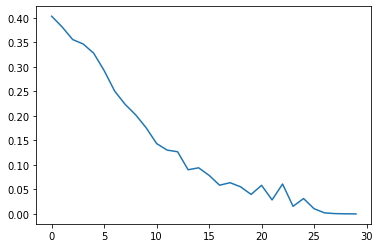

In [17]:
plt.plot([l/len(trainloader) for l in losses])

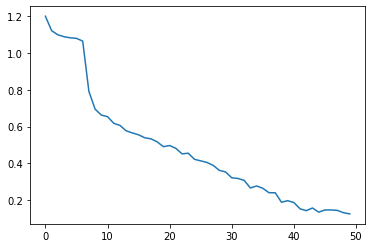

In [20]:
plt.plot([l/len(trainloader) for l in losses])

In [18]:
torch.save(model_res.state_dict(), './dukascopy/model_res50_2021-03-04.pth')

In [5]:
model_res = resnet50(pretrained=False, num_classes=3)
model_res.load_state_dict(torch.load('./dukascopy/model_res50.pth'))
if torch.cuda.is_available():
    model_res = model_res.cuda()

In [19]:
model_res.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [204]:
probs = []
pred_label = []
true_label = []
for images,labels in trainloader:
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()

    outputs = model_res(images)
    _, preds = torch.max(outputs.data, 1)
    pred_label += preds.cpu().tolist()
    true_label += labels.cpu().tolist()

In [20]:
probs = []
pred_label = []
true_label = []
for images,labels in valloader:
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()

    outputs = model_res(images)
    _, preds = torch.max(outputs.data, 1)
    pred_label += preds.cpu().tolist()
    true_label += labels.cpu().tolist()

In [21]:
probs = []
pred_label = []
true_label = []
for images,labels in dailyloader:
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()

    outputs = model_res(images)
    _, preds = torch.max(outputs.data, 1)
    pred_label += preds.cpu().tolist()
    true_label += labels.cpu().tolist()

In [21]:
pd.Series(pred_label).value_counts()

1    10005
0       22
2       11
dtype: int64

In [22]:
pd.Series(true_label).value_counts()

1    9977
0      32
2      29
dtype: int64

In [23]:
print(accuracy_score(true_label, pred_label),
precision_score(true_label, pred_label, average='macro'),
recall_score(true_label, pred_label, average='macro'),
f1_score(true_label, pred_label, average='macro'))

0.991133691970512 0.3768555116381203 0.3542419475713681 0.3608776911566089


In [27]:
def get_all_files(folder):
    all_images = []
    for path, subdirs, files in os.walk(folder):
        for name in files:
            all_images.append(os.path.join(path, name))
    return all_images

In [75]:
all_images = get_all_files('./stock_graphs/')
# all_images = [f for f in listdir('./dukascopy'+'/val/buy') if f.endswith('.png')]+[f for f in listdir('./dukascopy'+'/val/hold') if f.endswith('.png')]+[f for f in listdir('./dukascopy'+'/val/sell') if f.endswith('.png')]
# folder = './dukascopy'+'/stock_data/'
folder = './daily_stock_data/'
files = get_all_files(folder)
df = pd.DataFrame()
for file in files:
    if file == './daily_stock_data/MIN_2021-02-05.csv':
        break
    temp = pd.read_csv(file)
    temp.index = [f"{file.split('.')[0]}_{idx.isoformat().replace(':', '-')}.png" for idx in pd.to_datetime(temp['Local time'])]
    df = pd.concat([df, temp])

df.index = [f"{file.split('.')[0]}_{idx.isoformat().replace(':', '-')}.png" for idx in pd.to_datetime(df['Local time'])]
df_val = df[df.index.isin(all_images)]
profits = []
bought = None
bought_i = []
sell_i = []
for (i, (idx, row)), label in zip(enumerate(df.iterrows()), pred_label):
    if bought is None and label == 0:
        bought = row['Close']
        bought_i.append(i)
    if bought is not None and (label == 2):
        profits.append(row['Close'] - bought)
        bought = None
        sell_i.append(i)

In [68]:
sum(profits)

12.010799999999998

In [69]:
profits

[0.030000000000001137,
 0.02999999999999936,
 0.0,
 0.02999999999999936,
 0.019999999999999574,
 0.019999999999999574,
 -0.009999999999999787,
 0.059900000000000286,
 12.23,
 -0.11000000000000121,
 0.05000000000000071,
 -0.005000000000000782,
 0.049999999999998934,
 0.0,
 -0.06099999999999994,
 -0.09999999999999964,
 0.1200000000000001,
 -0.009999999999999787,
 0.02999999999999936,
 -0.040000000000000036,
 -0.009999999999999787,
 -0.1999999999999993,
 0.0,
 -0.07890000000000086,
 0.009999999999999787,
 -0.040000000000000924,
 -0.008099999999998886,
 -0.013799999999999812,
 0.02000000000000135,
 0.09889999999999866,
 0.0,
 -0.019999999999999574,
 0.10999999999999943,
 0.08499999999999996,
 0.019999999999999574,
 0.015000000000000568,
 0.1299999999999999,
 0.011799999999999145,
 0.019999999999999574,
 -0.06569999999999965,
 -0.017799999999999372,
 -0.029899999999999594,
 0.0,
 0.05000000000000071,
 0.0600000000000005,
 -6.0,
 0.025599999999999845,
 0.012500000000000178,
 0.02799999999999

In [93]:
df.index = pd.to_datetime(df['Local time'], utc=True)

In [95]:
df.index = pd.to_datetime(df.index, utc=True)

c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


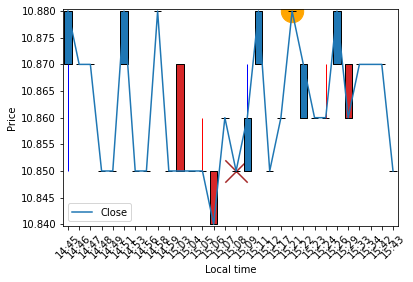

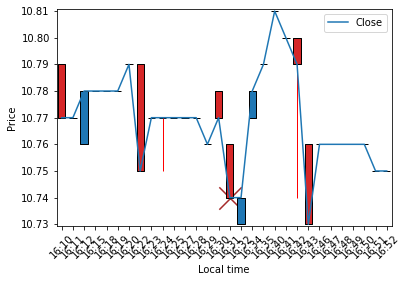

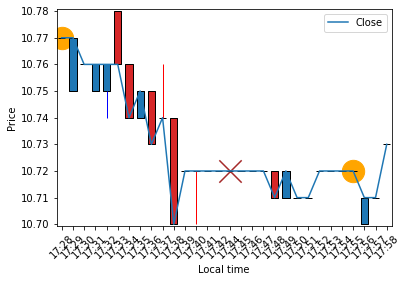

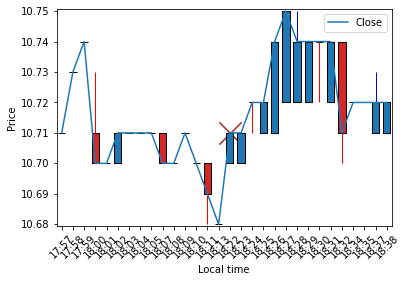

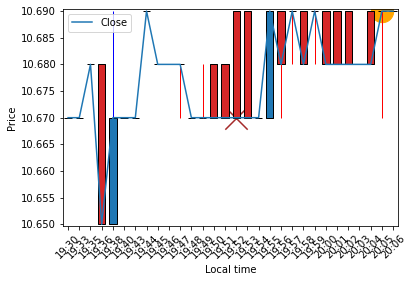

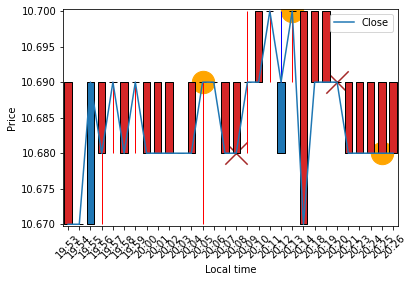

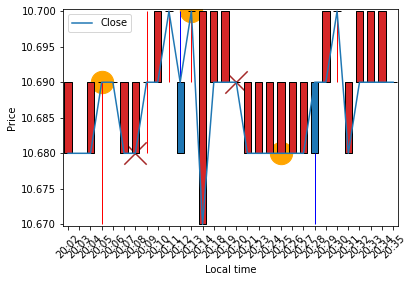

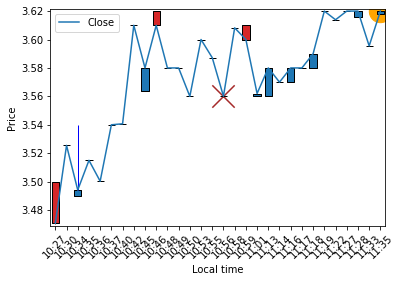

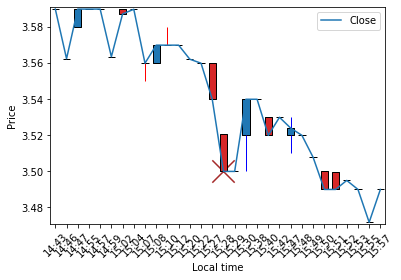

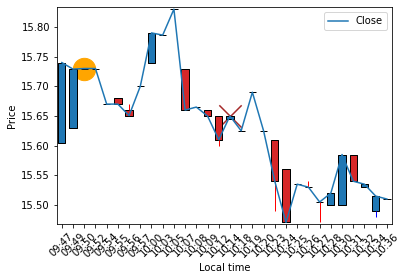

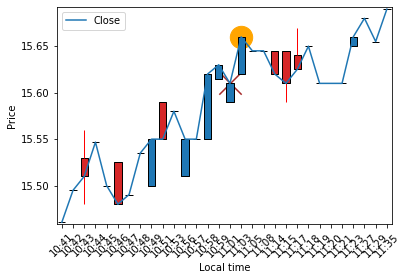

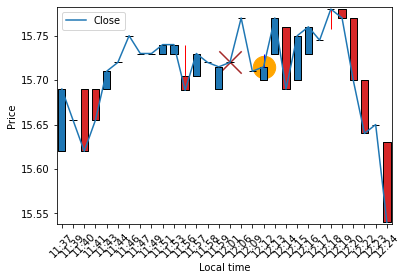

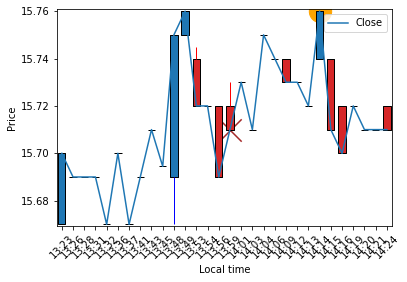

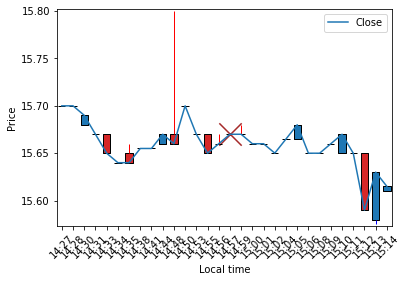

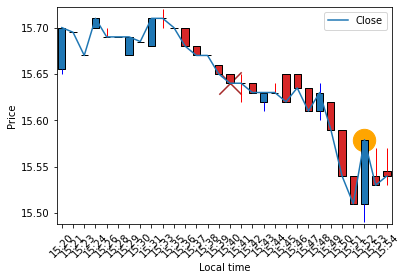

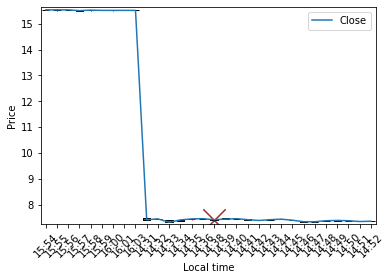

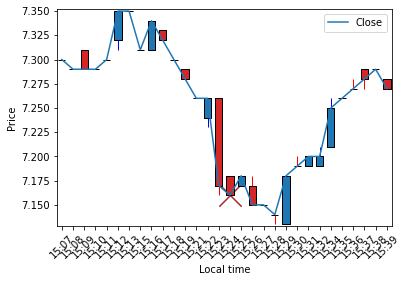

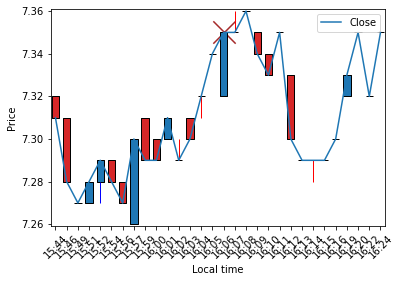

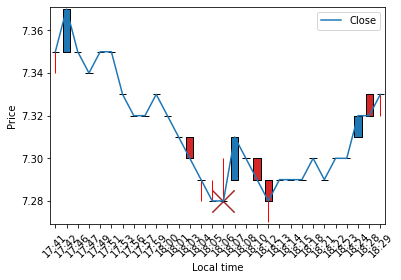

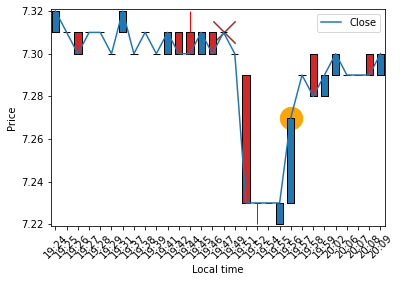

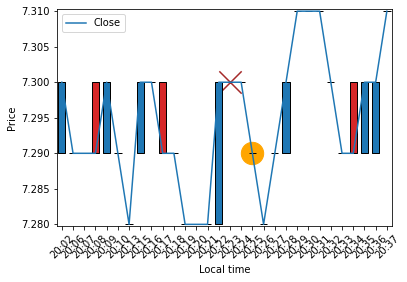

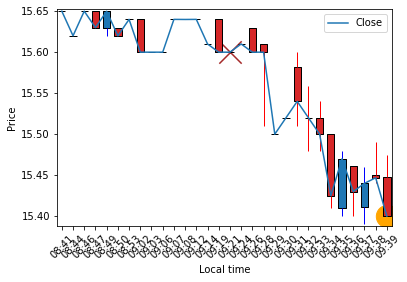

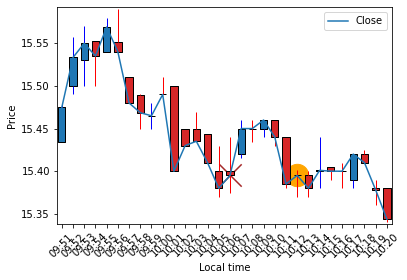

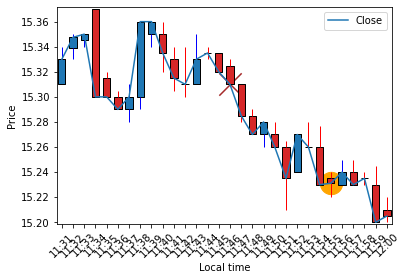

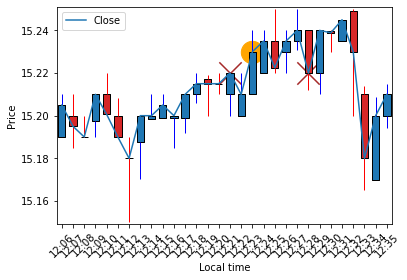

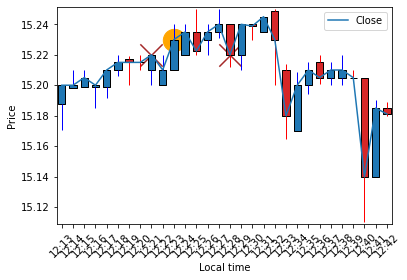

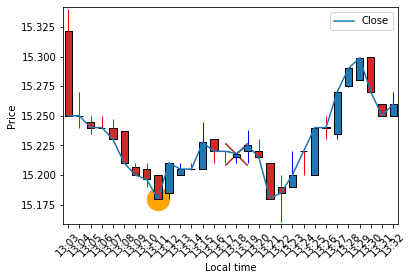

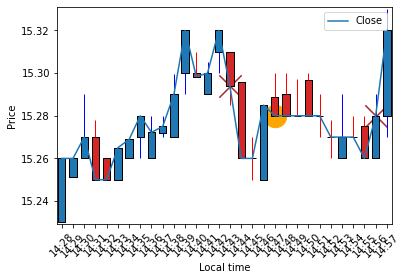

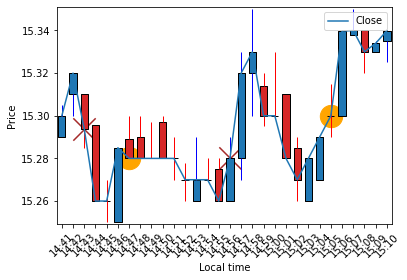

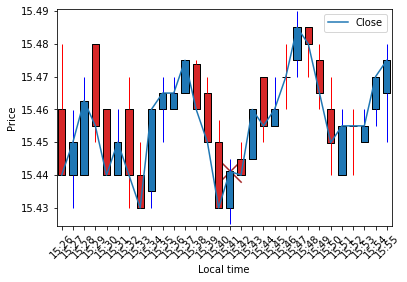

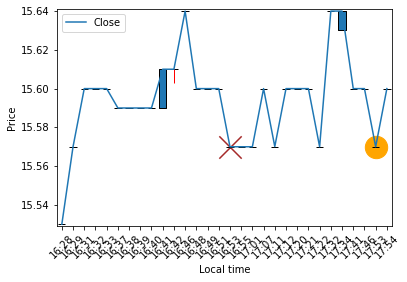

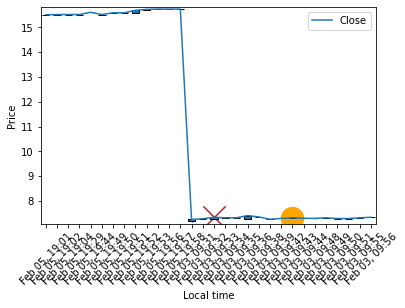

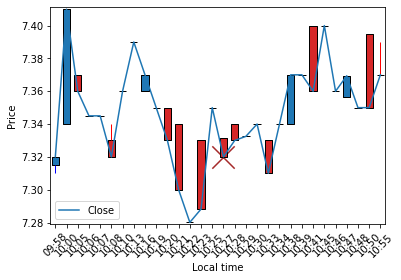

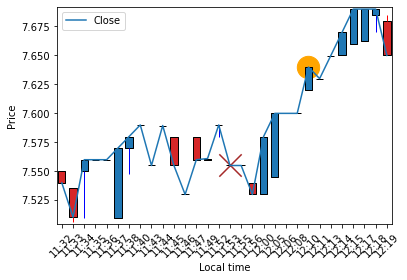

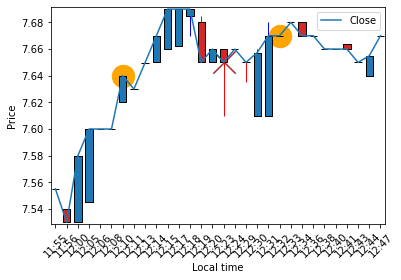

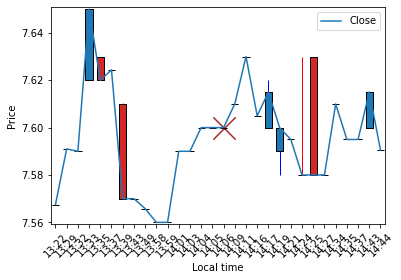

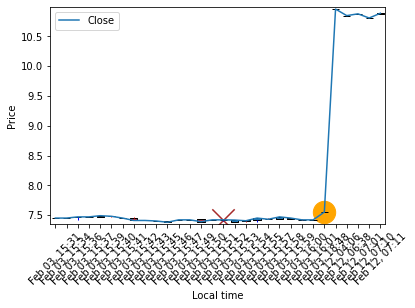

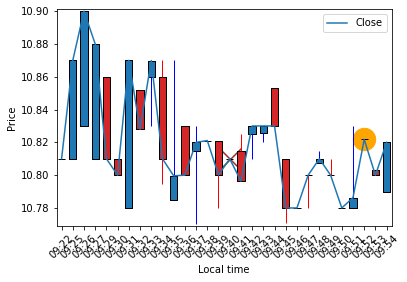

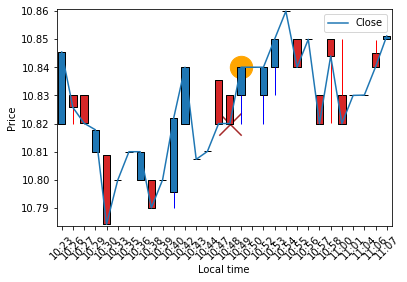

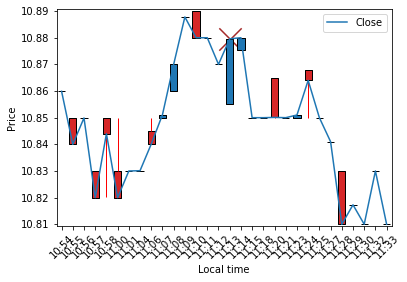

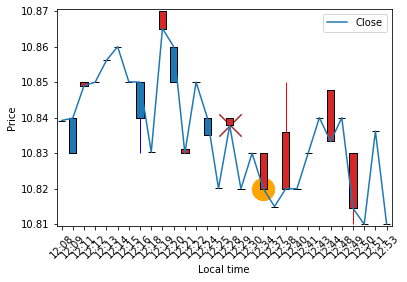

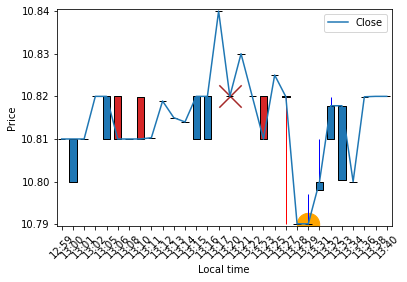

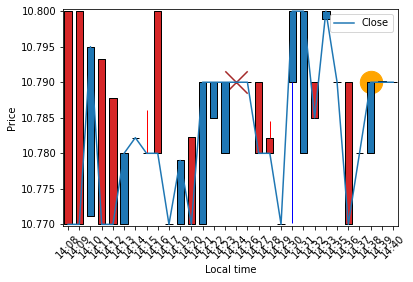

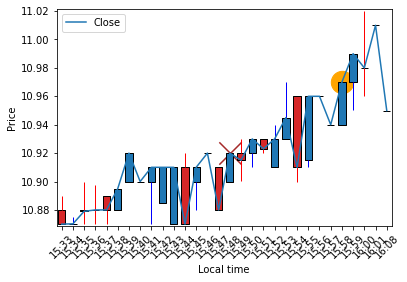

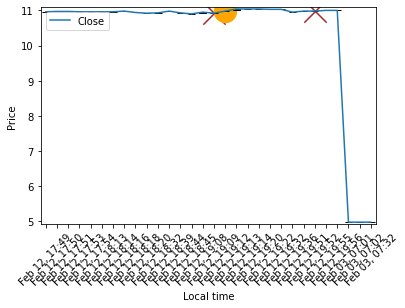

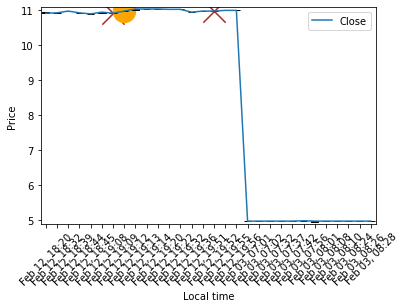

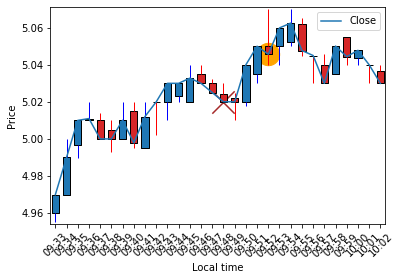

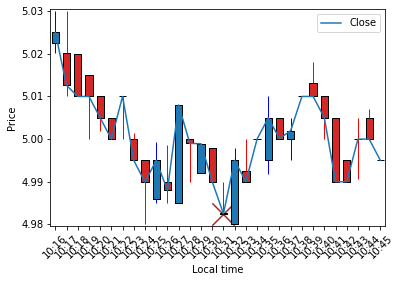

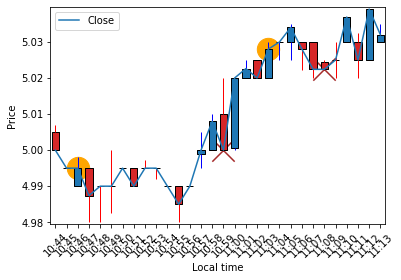

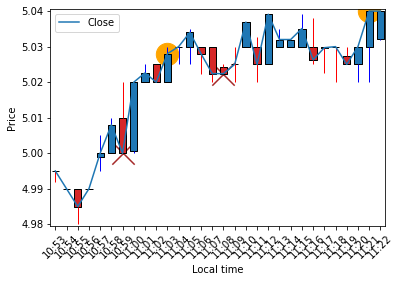

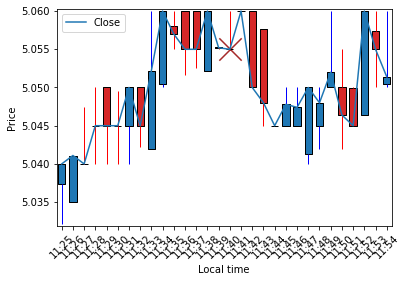

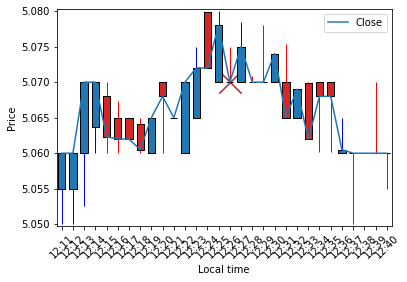

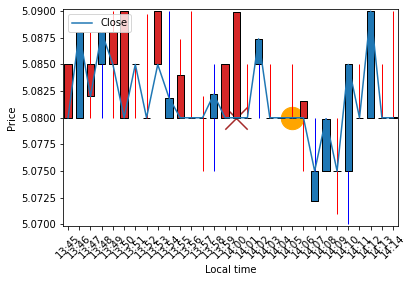

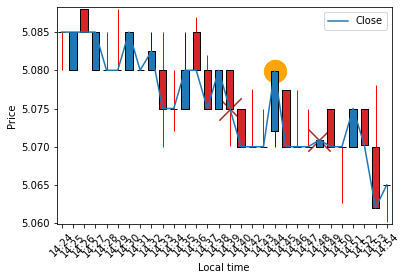

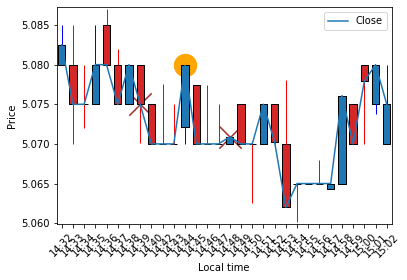

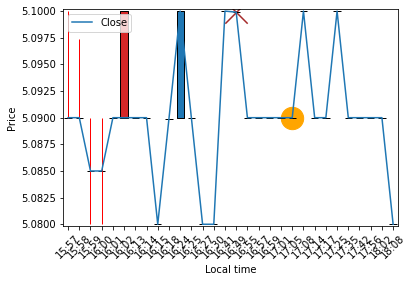

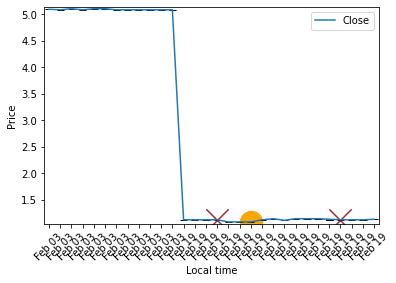

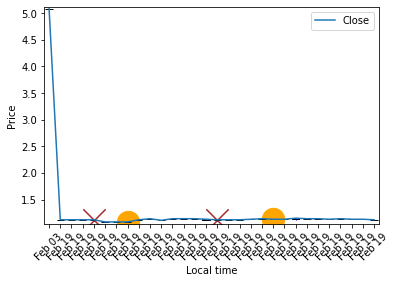

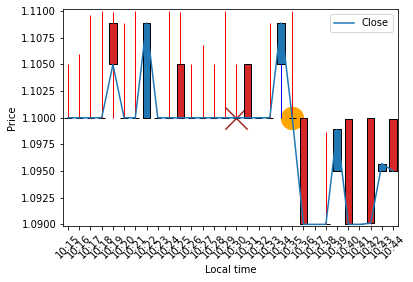

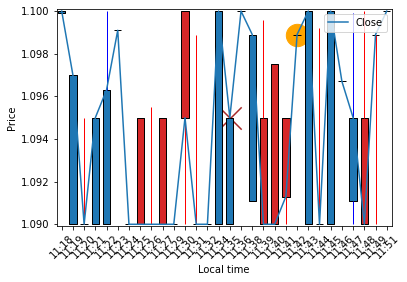

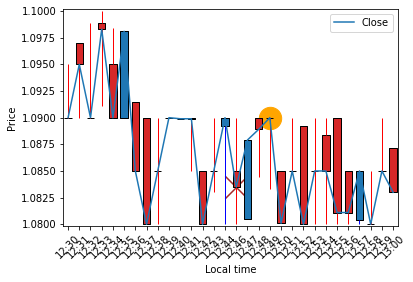

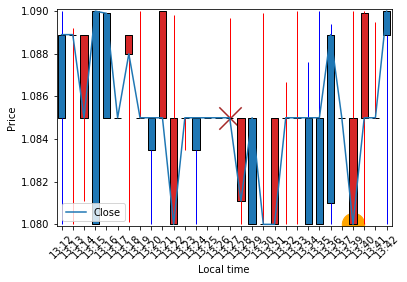

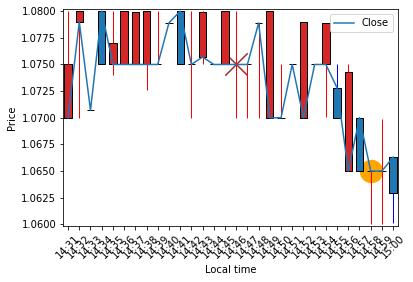

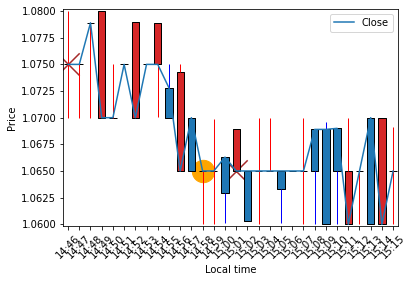

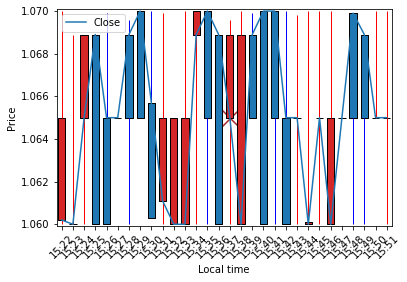

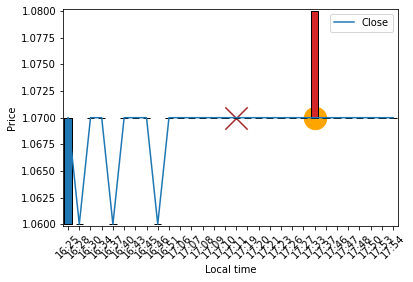

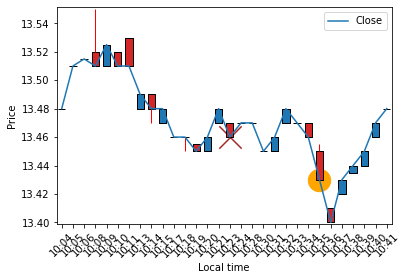

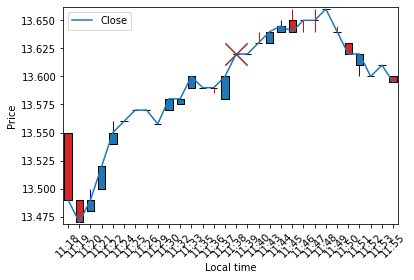

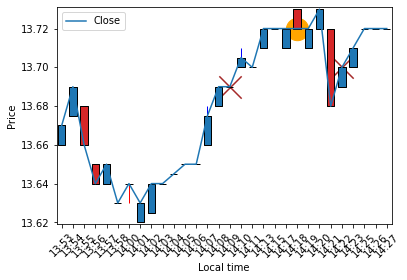

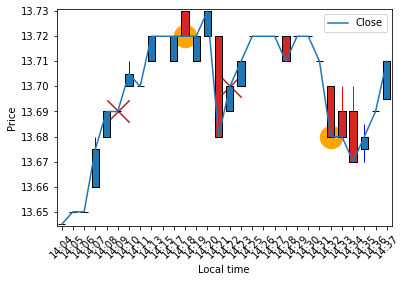

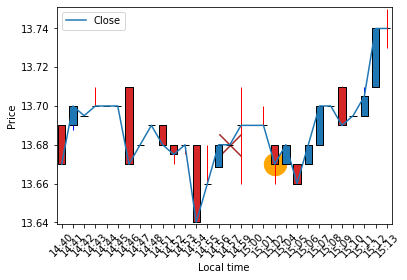

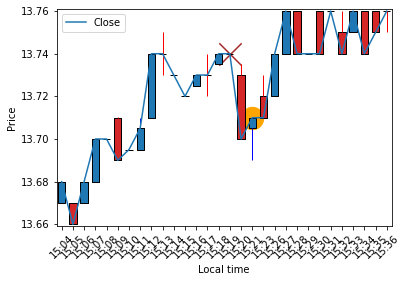

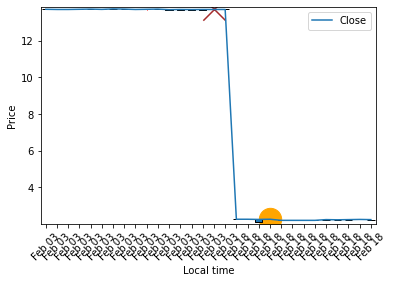

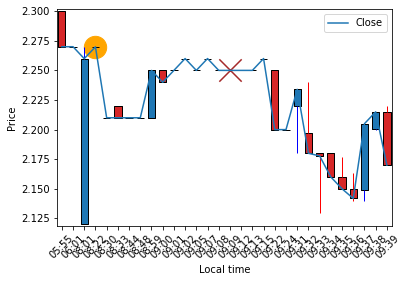

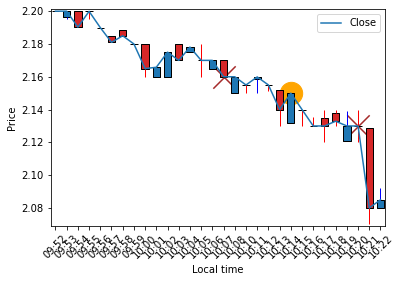

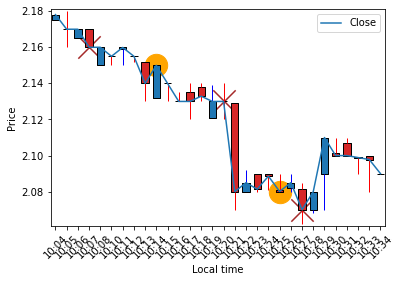

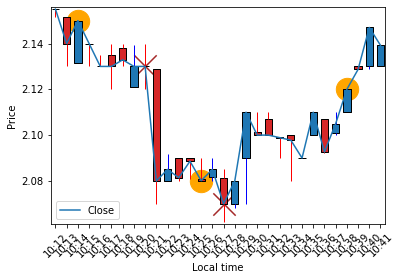

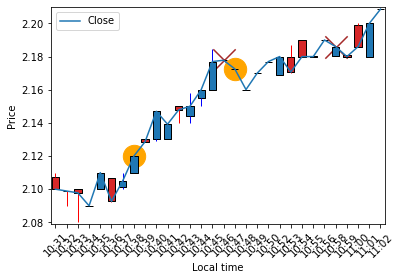

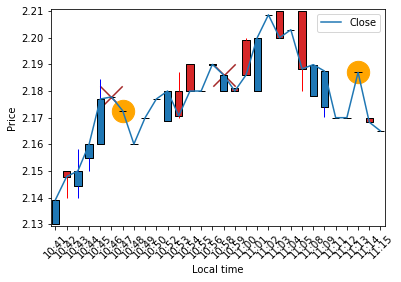

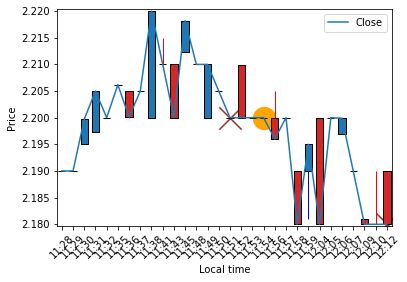

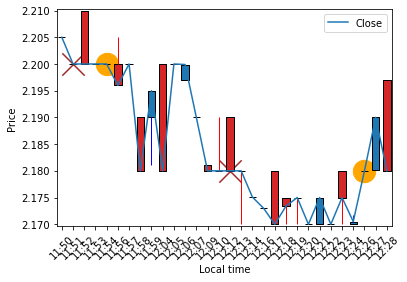

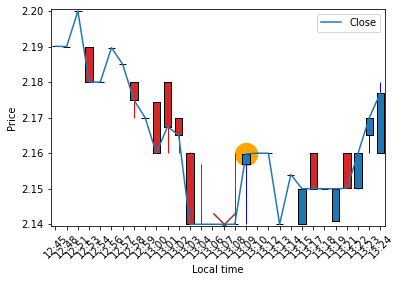

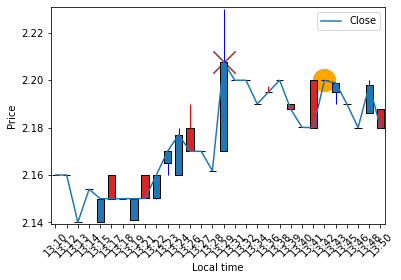

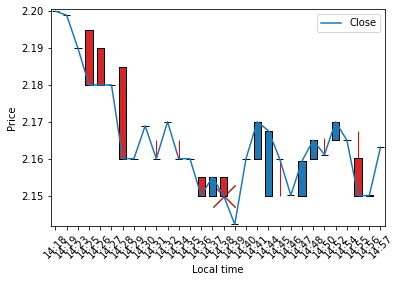

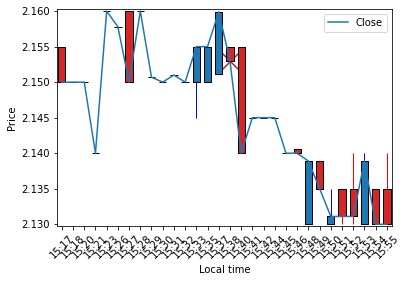

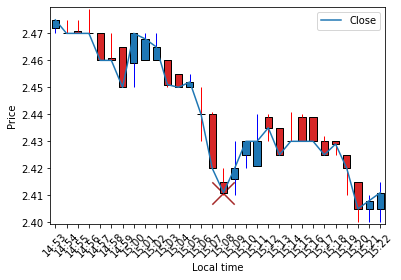

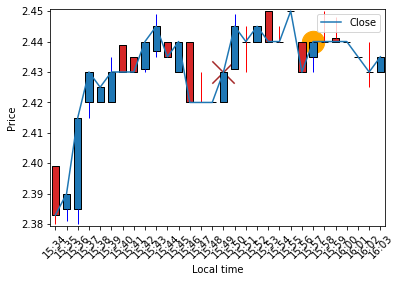

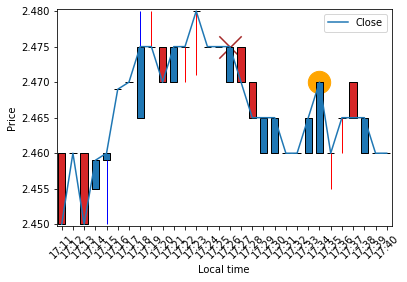

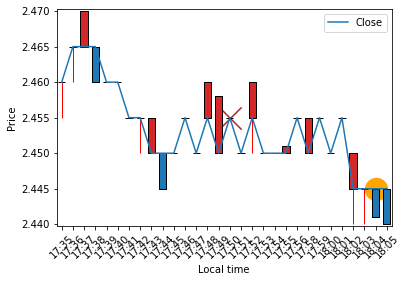

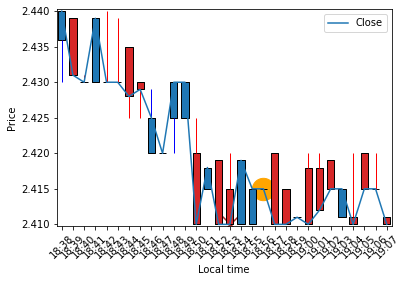

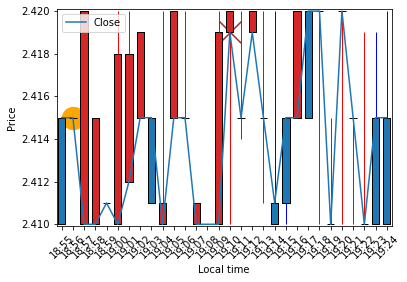

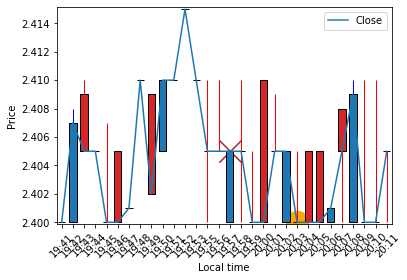

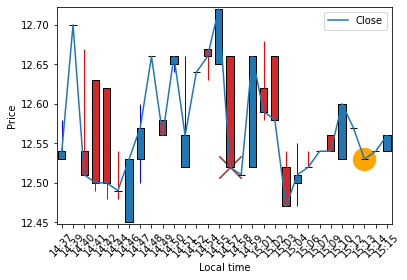

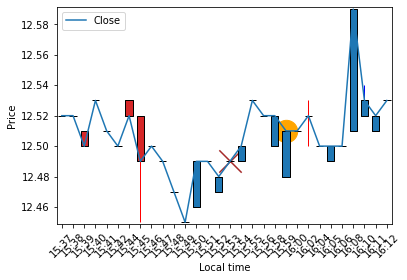

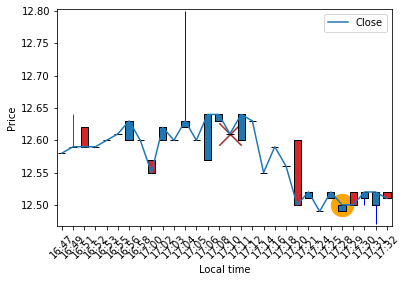

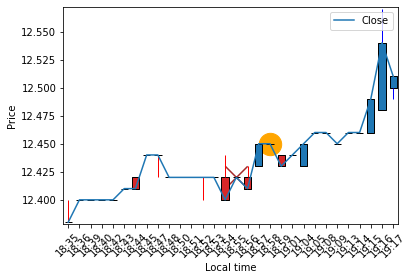

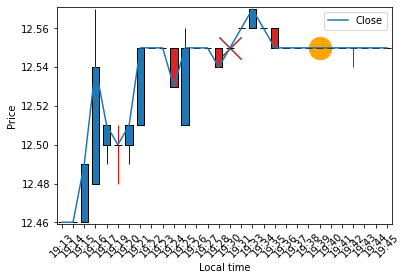

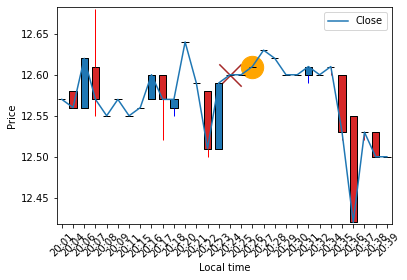

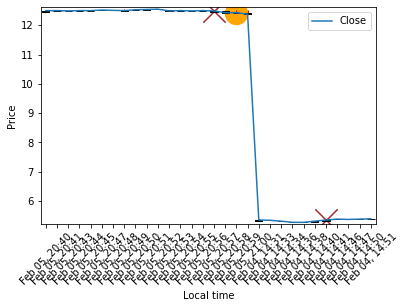

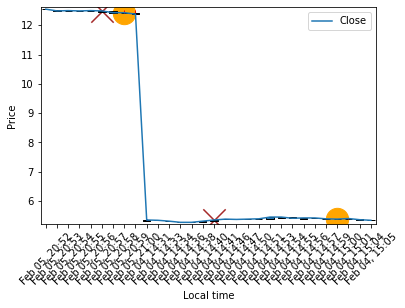

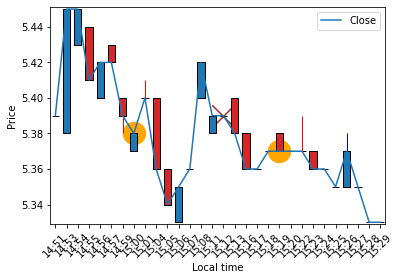

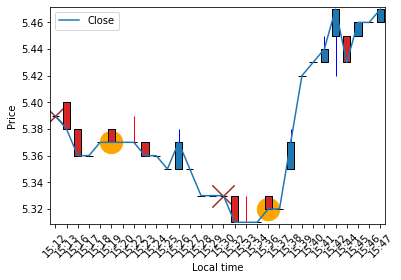

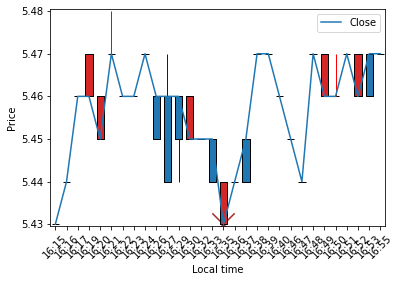

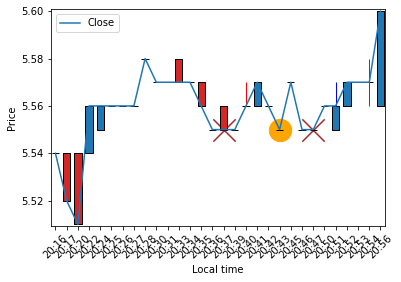

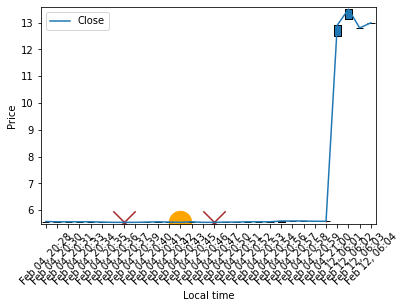

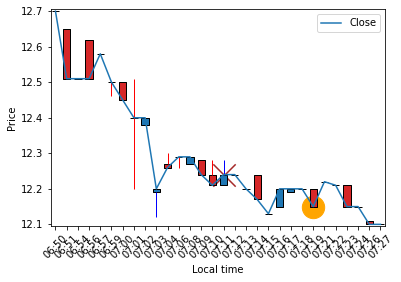

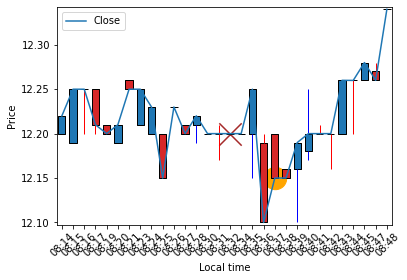

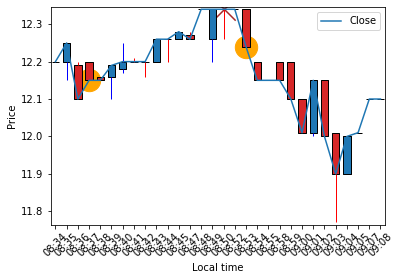

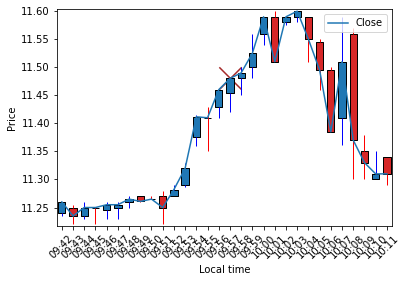

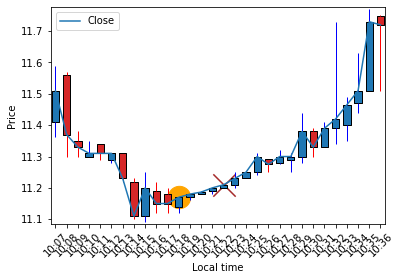

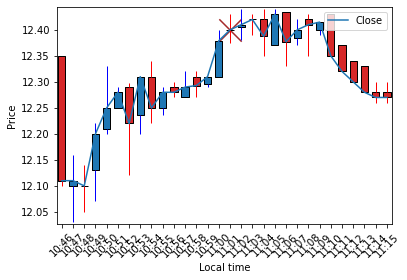

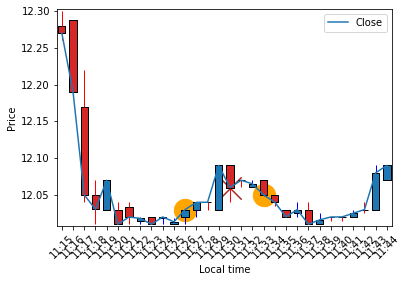

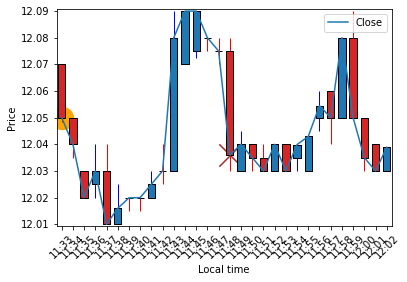

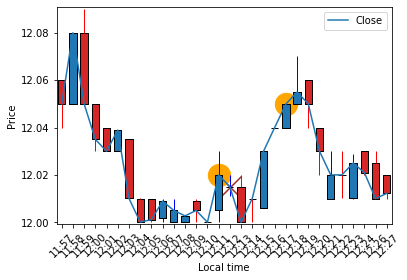

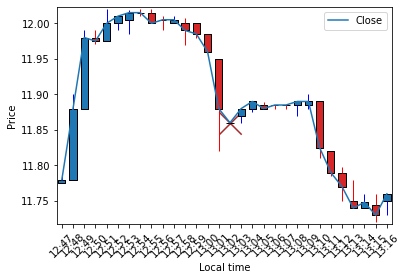

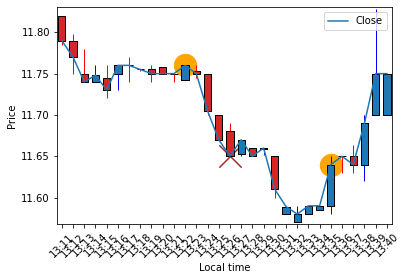

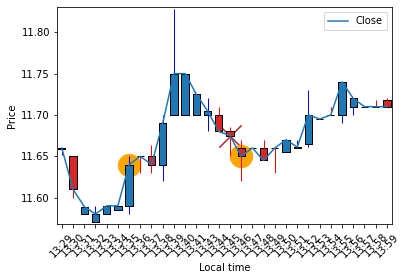

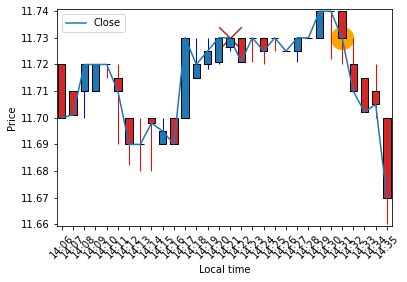

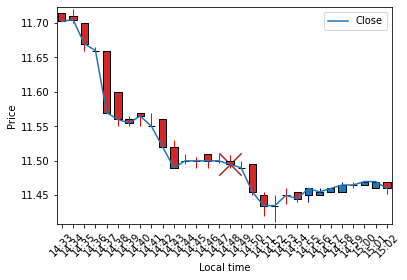

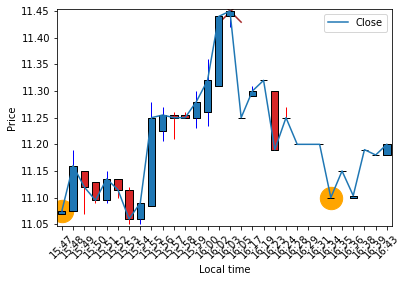

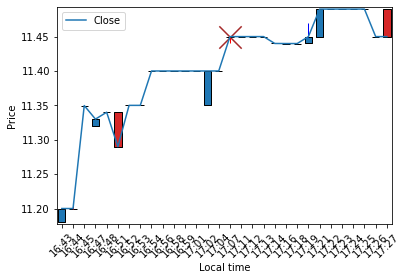

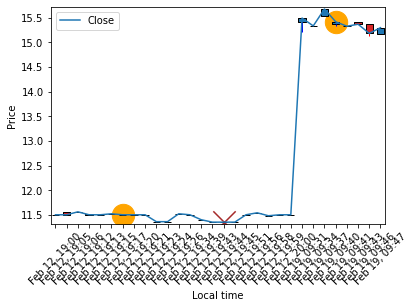

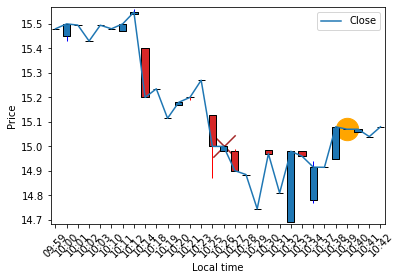

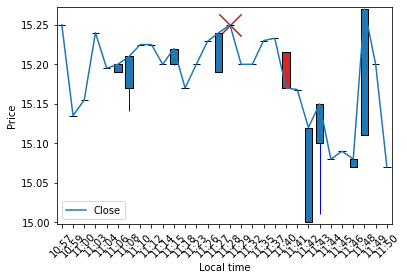

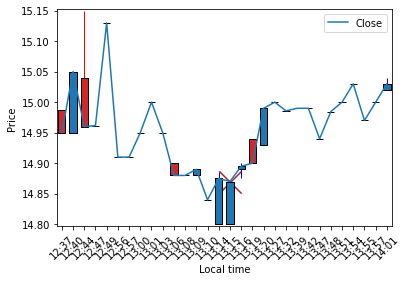

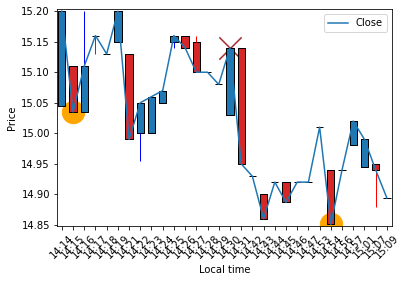

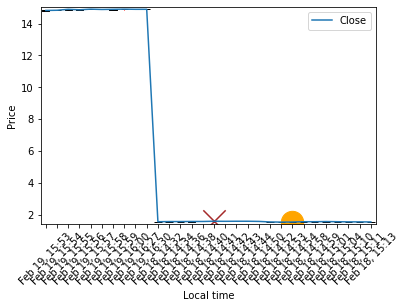

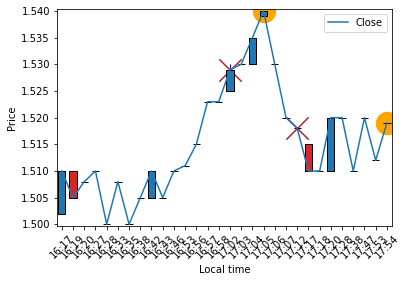

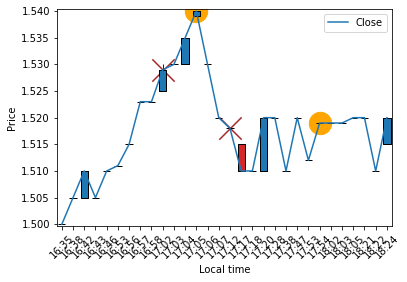

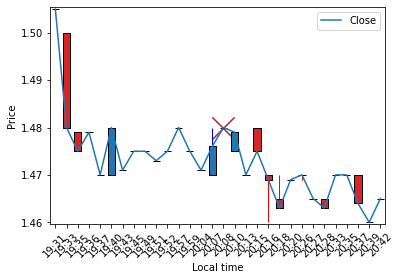

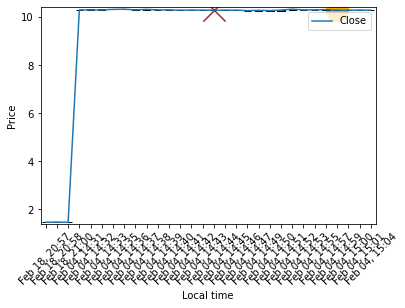

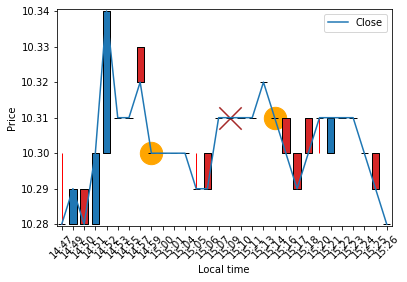

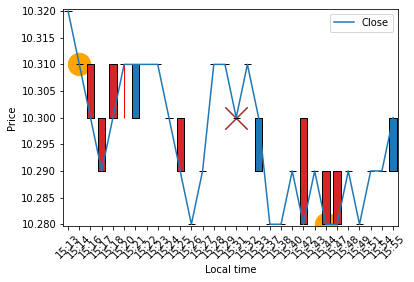

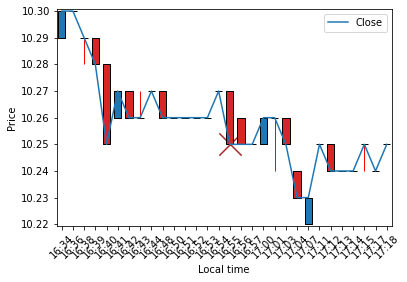

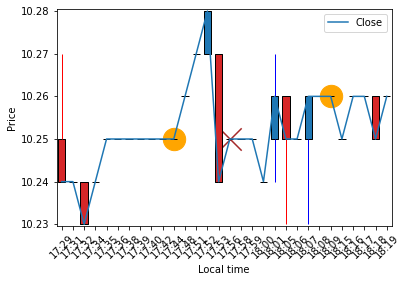

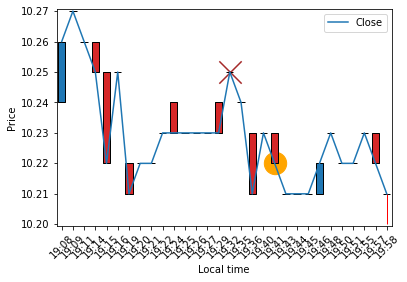

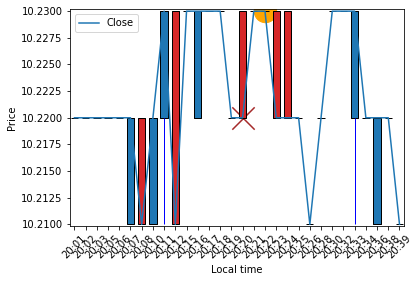

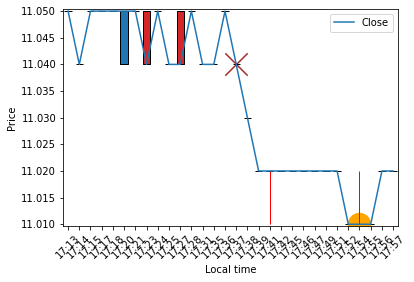

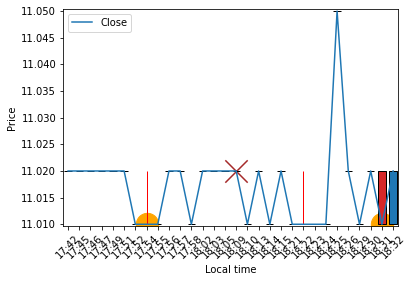

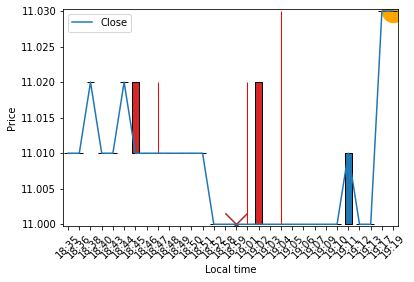

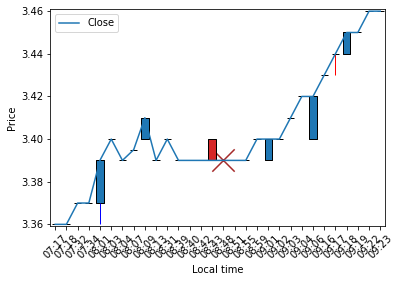

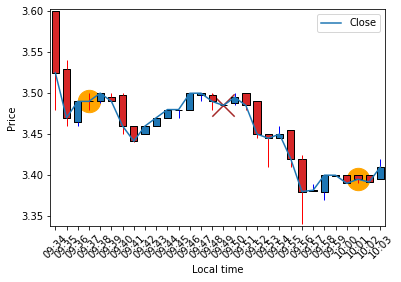

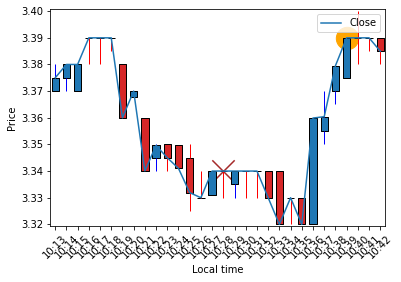

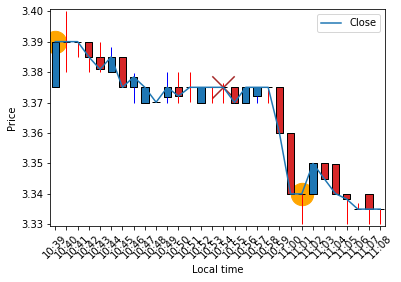

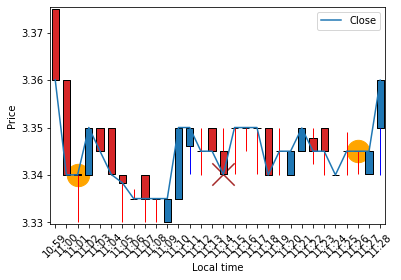

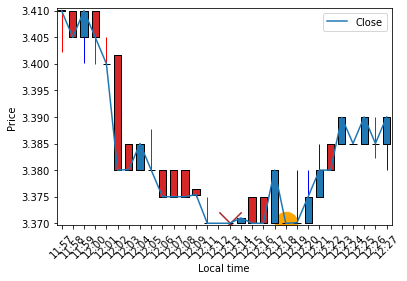

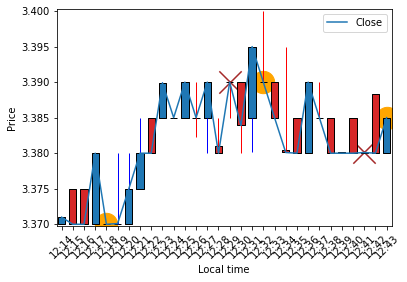

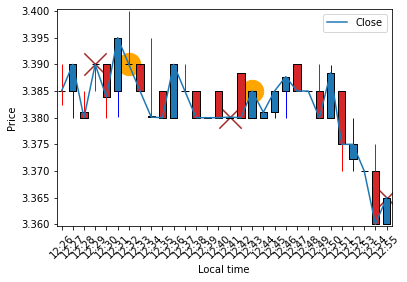

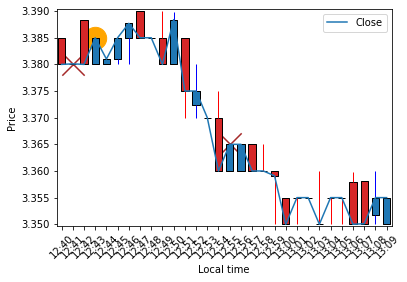

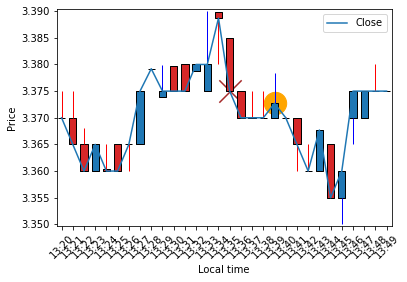

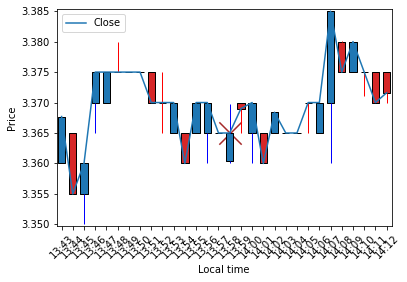

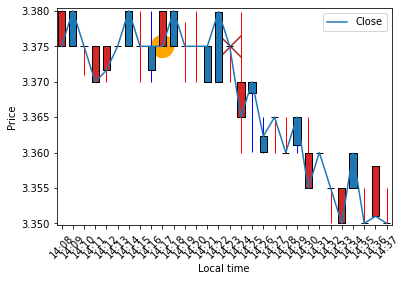

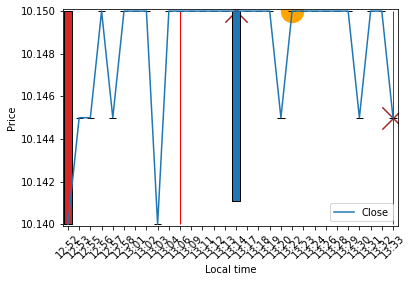

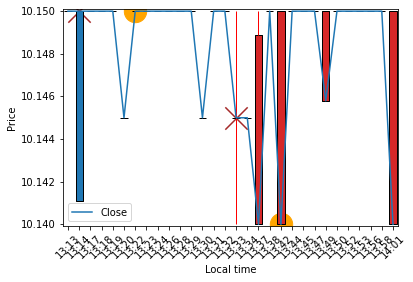

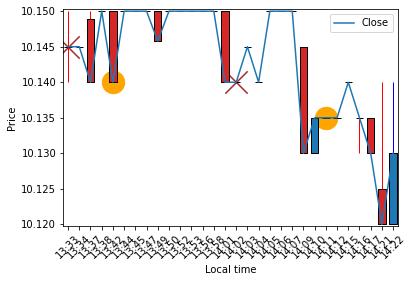

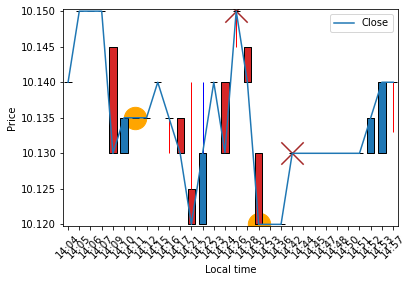

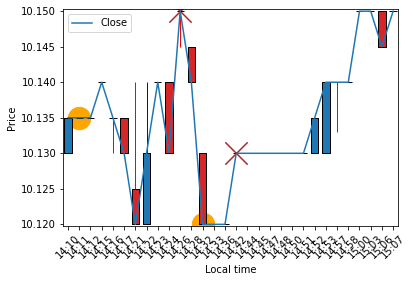

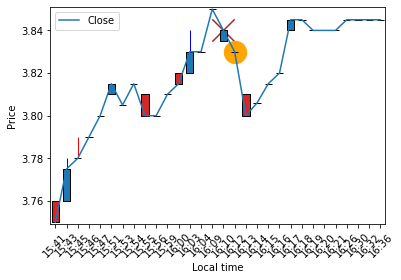

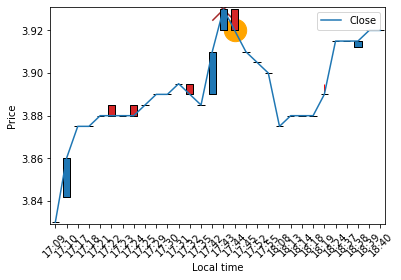

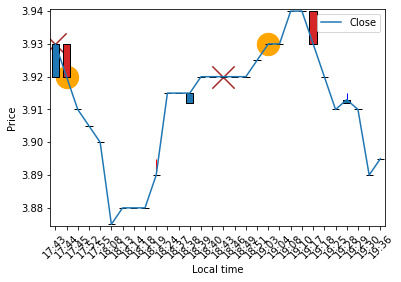

In [103]:
import mplfinance as fplt
df['Bought'] = [close if idx in bought_i else None for idx, close in enumerate(df['Close'])]
df['Sold'] = [close if idx in sell_i else None for idx, close in enumerate(df['Close'])]
for i in bought_i:
    ax = df.iloc[i-15:i+15].plot(kind='scatter', x='Local time', y='Bought', marker='x', color='brown', s=500)
    ax = df.iloc[i-15:i+15].plot(kind='scatter', x='Local time', y='Sold', marker='o', color='orange', s=500, ax=ax)
    ax = df.iloc[i-15:i+15].plot(x='Local time', y=['Close'], ax=ax)
    mc = fplt.make_marketcolors(
        up='tab:blue',down='tab:red',
        edge='black',
        wick={'up':'blue','down':'red'},
        volume='green', alpha=1.0
    )
    s  = fplt.make_mpf_style(marketcolors=mc, mavcolors=["yellow","orange",'brown'])

    fig = fplt.plot(
        df.iloc[i-15:i+15],
        type='candle',
        style=s,
#         volume=True,
        axisoff=True,
#         figsize=(3.2,3.2),
        tight_layout=True,
        ax=ax
    )

1


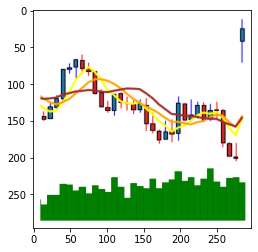

In [105]:
print(label)
img = image.imread(f"./dukascopy/stock_graphs/all/AAPL_2021-01-02T06-30-00+08-00.png")
plt.imshow(img)

In [ ]:
model_res.pr

In [102]:
t = (images[0].view(1, 3, 320, 320).cpu()[0]).reshape(320, 320,3).numpy()

In [16]:
images[15].cpu().shape

torch.Size([3, 296, 297])

In [27]:
t.shape

(320, 320, 3)

In [189]:
t = Image.fromarray(images[0].reshape(64,64,3).cpu().numpy(), 'RGB')

In [154]:
img = Image.open(f"./dukascopy/stock_graphs/all/AAPL_2021-01-02T06-30-00+08-00.png").convert("RGB")

In [173]:
fig[0]

TypeError: 'NoneType' object is not subscriptable

In [171]:
img = Image.open(f"./dukascopy/stock_graphs/all/AAPL_2021-01-02T06-30-00+08-00.png").convert("RGB")
outputs = model_res(TRANSFORM_IMG(img).reshape((1,3,256,256)).cuda())
_, preds = torch.max(outputs.data, 1)

In [187]:
preds[0].item()

1

In [ ]:
preds.cpu().tolist()

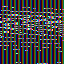

In [190]:
display(t)

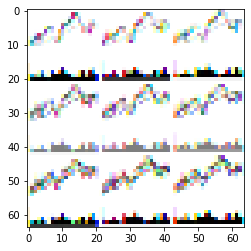

In [200]:
from matplotlib import pyplot as plt
plt.imshow(images[-5].reshape(64,64,3).cpu().numpy())

In [162]:
t = images[0]

In [167]:
labels[100]

IndexError: index 100 is out of bounds for dimension 0 with size 14

In [106]:
from os import listdir
import pandas as pd
hists = {}
path = './daily_stock_data/'
for file in [f for f in listdir(path) if f.endswith('.csv')]:
    try:
        hists[file[:-4]] = pd.read_csv(path+file, index_col='timestamp')
        hists[file[:-4]].index = pd.to_datetime(hists[file[:-4]].index)
    except:
        try:
            hists[file[:-4]] = pd.read_csv(path+file, index_col='time')
            hists[file[:-4]].index = pd.to_datetime(hists[file[:-4]].index)
        except:
            pass

In [111]:
files = [k for k in hists.keys() if k.endswith('2021-02-19')]

In [113]:
hist = hists[files[0]]

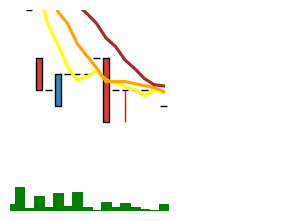

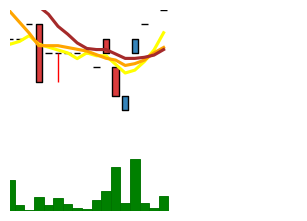

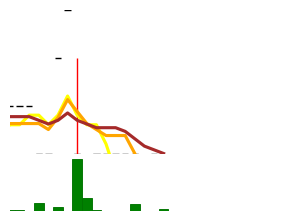

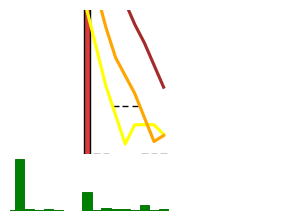

In [126]:
import mplfinance as fplt

mc = fplt.make_marketcolors(
                        up='tab:blue',down='tab:red',
                        edge='black',
                        wick={'up':'blue','down':'red'},
                        volume='green',
                       )

s  = fplt.make_mpf_style(marketcolors=mc, mavcolors=["yellow","orange",'brown'])

figs = []
for i in np.where(hist['label'].values == 'buy')[0]:
    figs.append(fplt.plot(
        hist.iloc[i-31:i-1],
        type='candle',
        style=s,
        volume=True,
        axisoff=True,
        mav=(5,8,13),
        figscale=0.5,
        xlim=(13, 43),
        ylim=(hist.iloc[i+13:i+43]['close'].min(), hist.iloc[i+13:i+43]['close'].max()),
        returnfig=True
#             savefig=f'./stock_graphs/{filename}/{filename}_{i}.jpeg'
    ))

In [140]:
data = []
for fig in figs:
    data.append(np.fromstring(fig[0].canvas.tostring_rgb(), dtype=np.uint8, sep=''))

c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
torch.nn.functional.softmax(outputs.data)[0].tolist()

c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


[1.4450421076617204e-05, 0.9996784925460815, 0.00030705402605235577]

In [ ]:
all_probs = []
all_labels = []
for image_file in [f for f in listdir('./live_graphs/') if f.endswith('.png')]:
    image_file = './live_graphs/' + image_file
    img = Image.open(image_file).convert("RGB")
    outputs = model_res(TRANSFORM_IMG(img).reshape((1,3,256,256)).cuda())
    probs = torch.nn.functional.softmax(outputs.data)[0].tolist()
    _, preds = torch.max(outputs.data, 1)
    label = preds[0].item()
    all_probs.append(probs)
    all_labels.append(label)

c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [ ]:
pd.set_option('display.max_rows', 1000)
pd.DataFrame(all_probs)[0].max()